In [ ]:
from bs4 import BeautifulSoup
import requests
import re
import time
import pandas as pd

# Function to scrape course description from a course page
def scrape_course_description(course_url):
    try:
        response = requests.get(course_url)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Look for the course description (often in a div or p with class like "courseblockdesc")
        description = soup.find('div', class_=re.compile('.*courseblockdesc.*'))
        if description:
            return description.get_text(strip=True)

        # Fallback: Look for any <p> or <div> with a detailed description
        paragraphs = soup.find_all(['p', 'div'])
        for p in paragraphs:
            text = p.get_text(strip=True)
            if len(text) > 50 and 'credit' in text.lower():  # Likely a course description
                return text

        return "No description found"
    except Exception as e:
        return f"Error: {str(e)}"

# Function to scrape curriculum and course descriptions from a program page
def scrape_curriculum(program_url):
    try:
        # Fetch the program page
        response = requests.get(program_url)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extract introductory curriculum text
        curriculum_section = soup.find('div', class_='f--wysiwyg')
        intro_text = ''
        if curriculum_section:
            intro_paragraphs = curriculum_section.find_all('p')
            intro_text = ' '.join([p.get_text(strip=True) for p in intro_paragraphs if p.get_text(strip=True)])

        # Find the "View Curriculum" link
        curriculum_link = None
        for a_tag in soup.find_all('a', class_='cta-link'):
            if 'View Curriculum' in a_tag.get_text():
                curriculum_link = a_tag['href']
                break

        # If "View Curriculum" link exists, scrape the catalog page
        courses_data = []
        if curriculum_link:
            # Ensure the link is a full URL
            if curriculum_link.startswith('/'):
                curriculum_link = f"https://www.pace.edu{curriculum_link}"
            response = requests.get(curriculum_link)
            catalog_soup = BeautifulSoup(response.text, 'html.parser')

            # Extract courses from the catalog page
            course_table = catalog_soup.find('table', class_='sc_courselist')
            if course_table:
                course_rows = course_table.find_all('tr')
                for row in course_rows:
                    cols = row.find_all('td')
                    if len(cols) >= 2:  # Ensure it's a course row
                        code_cell = cols[0].find('a')
                        if code_cell:
                            course_code = code_cell.get_text(strip=True)
                            course_title = cols[1].get_text(strip=True)
                            course_href = code_cell['href']
                            # Construct full course URL
                            course_url = f"https://catalog.pace.edu{course_href}" if course_href.startswith('/') else course_href
                            # Scrape course description
                            description = scrape_course_description(course_url)
                            courses_data.append({
                                'Course Code': course_code,
                                'Course Title': course_title,
                                'Description': description,
                                'Course URL': course_url
                            })
                            time.sleep(0.5)  # Rate limiting for course pages

        return {
            'Intro': intro_text,
            'Courses': courses_data,
            'Catalog URL': curriculum_link if curriculum_link else 'Not found'
        }
    except Exception as e:
        return {'Intro': f"Error: {str(e)}", 'Courses': [], 'Catalog URL': 'Error'}

# Step 1: Scrape graduate program links
url = 'https://www.pace.edu/find-your-program/graduate'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find all <a> tags and filter with regex
links = soup.find_all('a')
pattern = re.compile(r'^/program/[\w-]+(?:-ms|-mba|-mst|-jd|-llm|-ma|-phd|-edd|-dps|-certificate|-advanced-certificate|-of-advanced-graduate-study)$')

program_links = []
for link in links:
    href = link.get('href')
    if href and pattern.match(href):
        full_url = f"https://www.pace.edu{href}" if href.startswith('/') else href
        if full_url not in program_links:  # Avoid duplicates
            program_links.append(full_url)

# Step 2: Scrape curriculum and course descriptions for each program
data = []
for program_link in program_links:
    print(f"Scraping curriculum for: {program_link}")
    curriculum_data = scrape_curriculum(program_link)

    # Flatten the courses data for CSV
    if curriculum_data['Courses']:
        for course in curriculum_data['Courses']:
            data.append({
                'Program URL': program_link,
                'Program Name': program_link.split('/')[-1].replace('-', ' ').title(),
                'Curriculum Intro': curriculum_data['Intro'],
                'Course Code': course['Course Code'],
                'Course Title': course['Course Title'],
                'Course Description': course['Description'],
                'Course URL': course['Course URL'],
                'Catalog URL': curriculum_data['Catalog URL']
            })
    else:
        # If no courses found, still record the program info
        data.append({
            'Program URL': program_link,
            'Program Name': program_link.split('/')[-1].replace('-', ' ').title(),
            'Curriculum Intro': curriculum_data['Intro'],
            'Course Code': '',
            'Course Title': 'No courses found',
            'Course Description': '',
            'Course URL': '',
            'Catalog URL': curriculum_data['Catalog URL']
        })
    time.sleep(1)  # Rate limiting between program pages

# Step 3: Save to CSV
df = pd.DataFrame(data)
#df.to_csv('pace_graduate_curriculum_with_descriptions.csv', index=False)
#print("Curriculum and course descriptions saved to pace_graduate_curriculum_with_descriptions.csv")
df.head()

Scraping curriculum for: https://www.pace.edu/program/accounting-data-analytics-and-technologies-ms
Scraping curriculum for: https://www.pace.edu/program/accounting-public-accounting-cpa-prep-ms
Scraping curriculum for: https://www.pace.edu/program/accounting-public-accounting-cpa-prep-mba
Scraping curriculum for: https://www.pace.edu/program/adolescent-and-adolescent-special-education-mst
Scraping curriculum for: https://www.pace.edu/program/adolescent-education-mst
Scraping curriculum for: https://www.pace.edu/program/applied-quantitative-economic-analysis-and-policy-ms
Scraping curriculum for: https://www.pace.edu/program/arts-and-entertainment-management-mba
Scraping curriculum for: https://www.pace.edu/program/arts-and-entertainment-management-ms
Scraping curriculum for: https://www.pace.edu/program/bilingual-education-certificate-of-advanced-graduate-study
Scraping curriculum for: https://www.pace.edu/program/biochemistry-and-molecular-biology-ms
Scraping curriculum for: https://

Program URL  \
0  https://www.pace.edu/program/accounting-data-a...   
1  https://www.pace.edu/program/accounting-data-a...   
2  https://www.pace.edu/program/accounting-data-a...   
3  https://www.pace.edu/program/accounting-data-a...   
4  https://www.pace.edu/program/accounting-data-a...   

                                    Program Name  \
0  Accounting Data Analytics And Technologies Ms   
1  Accounting Data Analytics And Technologies Ms   
2  Accounting Data Analytics And Technologies Ms   
3  Accounting Data Analytics And Technologies Ms   
4  Accounting Data Analytics And Technologies Ms   

                                    Curriculum Intro Course Code  \
0  Developed in consultation with leading account...     MBA 810   
1  Developed in consultation with leading account...      IS 613   
2  Developed in consultation with leading account...      IS 641   
3  Developed in consultation with leading account...      IS 680   
4  Developed in consultation with leading account...    ACC 060A   

                                        Course Title  \
0                  Business Analytics and Statistics   
1                        Database Management Systems   
2                  Information Security and Controls   
3  Data Science I: Introduction to Data Science a...   
4        CPA Review - Financial Accounting Reporting   

                                  Course Description  \
0  2025-2026 Edition2025-2026 Edition/​search/​Se...   
1  2025-2026 Edition2025-2026 Edition/​search/​Se...   
2  2025-2026 Edition2025-2026 Edition/​search/​Se...   
3  2025-2026 Edition2025-2026 Edition/​search/​Se...   
4  2025-2026 Edition2025-2026 Edition/​search/​Se...   

                                      Course URL  \
0   https://catalog.pace.edu/search/?P=MBA%20810   
1    https://catalog.pace.edu/search/?P=IS%20613   
2    https://catalog.pace.edu/search/?P=IS%20641   
3    https://catalog.pace.edu/search/?P=IS%20680   
4  https://catalog.pace.edu/search/?P=ACC%20060A   

                                         Catalog URL  
0  https://catalog.pace.edu/graduate/schools/lubi...  
1  https://catalog.pace.edu/graduate/schools/lubi...  
2  https://catalog.pace.edu/graduate/schools/lubi...  
3  https://catalog.pace.edu/graduate/schools/lubi...  
4  https://catalog.pace.edu/graduate/schools/lubi...

In [ ]:
import pandas as pd
filepath = '/content/course_descriptions.csv'
df = pd.read_csv(filepath)
df.head()

Course                                        Description
0     NaN  CS 623  Database Management Systems  (3 credit...
1     NaN  CS 661  Python Programming  (3 credits)  \nThi...
2     NaN  CS 660  Mathematical Foundations of Analytics ...
3     NaN  CS 673  Scalable Databases  (3 credits)  \nAft...
4     NaN  CS 675  Introduction to Data Science  (3 credi...

In [ ]:
df['Description'][1]

"CS 661  Python Programming  (3 credits)  \nThis course introduces students to the Python programming language with an emphasis on Python's data analytics libraries. Students will learn the fundamentals of Python and key modules including: scipy, numpy, scikit-learn, pandas, statsmodels, and matplotlib . The course covers basic language syntax, object types, variables, reading data from files and writing to files. Building on these concepts, students will create functions, and learn how to control program flow. Students will use Python to clean and prepare data, conduct exploratory data analysis, and build predictive models.\nCourse Rotation: NYC & PLV: Fall & Sprng\nPrerequisites: This course does not have a prerequisite."

In [ ]:
import pandas as pd
filepath1 = '/content/DATA SCIENCE JOBS.CSV'
cd = pd.read_csv(filepath1)
cd.head()

Num                                           JobTitle        Company  \
0    1                                       Data Analyst     Yodawy Med   
1    2  Data & Analytics Manager Dubai-United Arab Emi...         GroupM   
2    3  Data & Analytics Director Dubai-United Arab Em...         GroupM   
3    4                           Senior Data Scientist II  Alphapartners   
4    5                           Senior Data Scientist II         Careem   

                     Location         Time                    Job Type  \
0      Mohandessin-Giza-Egypt   3 days ago  Full Time | Work From Home   
1  Dubai-United Arab Emirates  7 hours ago                   Full Time   
2  Dubai-United Arab Emirates    1 day ago                   Full Time   
3  Dubai-United Arab Emirates    1 day ago                   Full Time   
4  Dubai-United Arab Emirates    1 day ago                   Full Time   

      Experience                                     Job Categories  \
0    Entry Level  IT/Software Development | Analyst/Research | E...   
1  Not specified  Administration | IT/Software Development | Eng...   
2  Not specified  Administration | IT/Software Development | Eng...   
3  Not specified  R&D/Science | IT/Software Development | Engine...   
4  Not specified  R&D/Science | IT/Software Development | Engine...   

                                          Job Skills  \
0  Analysis | analytical | Communication skills |...   
1  Information Technology (IT) | Computer Science...   
2  Information Technology (IT) | Computer Science...   
3  Computer Science | Engineering | Information T...   
4  Computer Science | Engineering | Information T...   

                                             Job URL  
0  https://wuzzuf.net/jobs/p/HAUXcNyYg78s-Data-An...  
1  https://wuzzuf.net/jobs/p/k9Xn3KWgUlSo-Data-An...  
2  https://wuzzuf.net/jobs/p/5htjgvq0hPvg-Data-An...  
3  https://wuzzuf.net/jobs/p/T5W2p0XgpwIg-Senior-...  
4  https://wuzzuf.net/jobs/p/hBkd1Nwzh3Dj-Senior-...

In [ ]:
!pip install numpy==1.26.4
!pip install pandas==2.2.2
!pip install scikit-learn==1.5.0
!pip install spacy==3.7.5
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.6.0/en_core_web_md-3.6.0-py3-none-any.whl
import pandas as pd
import spacy
import os
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load spaCy model
nlp = spacy.load("en_core_web_md")

# Load the CSV files
course_filepath = '/content/course_descriptions.csv'
job_filepath = '/content/DATA SCIENCE JOBS.CSV'
df = pd.read_csv(course_filepath)
cd = pd.read_csv(job_filepath)

# Step 1: Extract skills from course descriptions
def extract_course_skills(description):
    if pd.isna(description):
        return []
    doc = nlp(description)
    skills = []
    # Look for noun phrases and specific keywords related to skills
    for chunk in doc.noun_chunks:
        skill = chunk.text.lower()
        if any(keyword in skill for keyword in ["python", "data", "analysis", "modeling", "programming", "database", "machine learning"]):
            skills.append(skill)
    return skills

# Apply to all course descriptions
course_skills_list = df['Description'].apply(extract_course_skills)
all_course_skills = set()
for skills in course_skills_list:
    all_course_skills.update(skills)

# Step 2: Extract skills from job postings
def extract_job_skills(job_skills):
    if pd.isna(job_skills):
        return []
    # Split by '|' and clean
    skills = job_skills.lower().split(" | ")
    return [skill.strip(" ...") for skill in skills]

# Apply to all job postings
job_skills_list = cd['Job Skills'].apply(extract_job_skills)
all_job_skills = set()
for skills in job_skills_list:
    all_job_skills.update(skills)

# Step 3: Compute similarity between course and job skills
def compute_similarity(skill1, skill2):
    doc1 = nlp(skill1)
    doc2 = nlp(skill2)
    return doc1.similarity(doc2)

# Create a similarity matrix
course_skills = list(all_course_skills)
job_skills = list(all_job_skills)
similarity_scores = []
for course_skill in course_skills:
    scores = []
    for job_skill in job_skills:
        score = compute_similarity(course_skill, job_skill)
        scores.append(score)
    similarity_scores.append(scores)

# Convert to DataFrame
similarity_df = pd.DataFrame(similarity_scores, index=course_skills, columns=job_skills)

# Step 4: Save results
os.makedirs("output", exist_ok=True)
similarity_df.to_csv("output/skill_comparison.csv")
print("Similarity scores saved to output/skill_comparison.csv")

  Using cached spacy-3.7.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (27 kB)
  Using cached thinc-8.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
Using cached spacy-3.7.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.6 MB)
Using cached thinc-8.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (920 kB)
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.12
    Uninstalling thinc-8.1.12:
      Successfully uninstalled thinc-8.1.12
  Attempting uninstall: spacy
    Found existing installation: spacy 3.6.1
    Uninstalling spacy-3.6.1:
      Successfully uninstalled spacy-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-md 3.6.0 requires spacy<3.7.0,>=3.6.0, but you have spacy 3.7.5 which is incompatible.
  Using cached https://github.com/e

<ipython-input-1-62821716ac56>:58: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return doc1.similarity(doc2)


Similarity scores saved to output/skill_comparison.csv


In [ ]:
filepath3 = '/content/output/skill_comparison.csv'
df3 = pd.read_csv(filepath3)
df3.head()

Unnamed: 0  configuration  spring boot  \
0                    efficient data processing       0.732558     0.272160   
1                              graph databases       0.653804     0.212688   
2           some key machine learning concepts       0.634159     0.376465   
3                   cs 673  scalable databases       0.525032     0.250274   
4  machine learning and data mining techniques       0.745293     0.359329   

       acca  kubernetes  it manager  performance management  customer support  \
0 -0.105141    0.315407    0.366562                0.697869          0.672714   
1 -0.024323    0.391817    0.294866                0.481604          0.442521   
2 -0.022722    0.226919    0.423668                0.649702          0.612721   
3 -0.056344    0.289988    0.255143                0.379838          0.454467   
4 -0.019570    0.243919    0.362569                0.774099          0.680506   

   erp admin  fastapi  ...  firewall  area sales   fintech    oracle  \
0   0.401733      0.0  ...  0.475100    0.467651  0.342268  0.350785   
1   0.404839      0.0  ...  0.464952    0.358268  0.287770  0.403489   
2   0.340519      0.0  ...  0.414457    0.372625  0.461574  0.290933   
3   0.430461      0.0  ...  0.470127    0.298928  0.246696  0.251220   
4   0.328705      0.0  ...  0.445811    0.507656  0.418359  0.300857   

   computer skills  digitization     html5  laravel developer  \
0         0.606852      0.694173  0.297289           0.411527   
1         0.519659      0.526180  0.466641           0.317780   
2         0.712311      0.666163  0.286897           0.358182   
3         0.451629      0.394344  0.381801           0.234226   
4         0.729486      0.770722  0.251146           0.455429   

   full stack development   science  
0                0.596169  0.478221  
1                0.499825  0.407648  
2                0.633200  0.574425  
3                0.447912  0.228736  
4                0.656495  0.619409  

[5 rows x 726 columns]

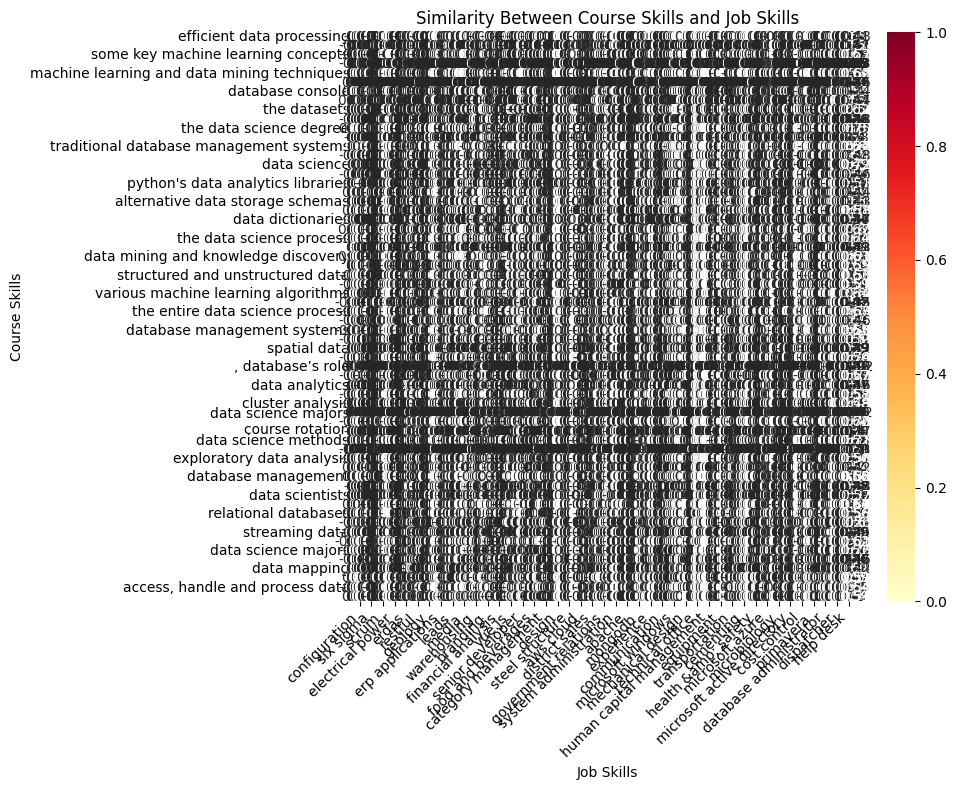

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, annot=True, cmap="YlOrRd", vmin=0, vmax=1)
plt.title("Similarity Between Course Skills and Job Skills")
plt.xlabel("Job Skills")
plt.ylabel("Course Skills")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

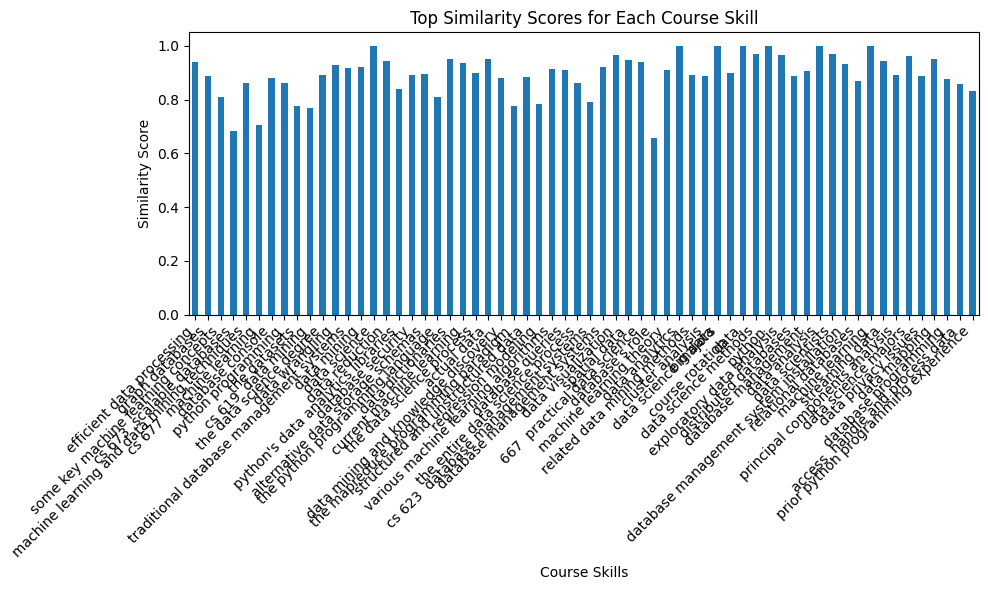

In [ ]:
top_matches = similarity_df.idxmax(axis=1)  # Job skill with highest similarity for each course skill
top_scores = similarity_df.max(axis=1)

plt.figure(figsize=(10, 6))
top_scores.plot(kind='bar')
plt.title("Top Similarity Scores for Each Course Skill")
plt.xlabel("Course Skills")
plt.ylabel("Similarity Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

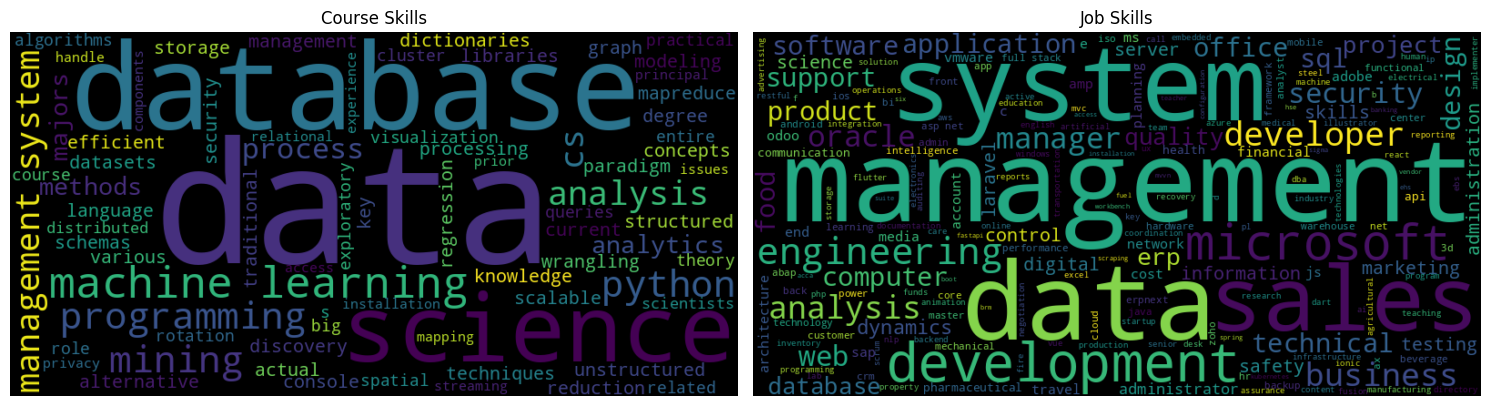

In [ ]:
from wordcloud import WordCloud

# Combine all course skills into a single string
course_text = " ".join(all_course_skills)
job_text = " ".join(all_job_skills)

# Generate word clouds
wordcloud_course = WordCloud(width=800, height=400).generate(course_text)
wordcloud_job = WordCloud(width=800, height=400).generate(job_text)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_course, interpolation='bilinear')
plt.title("Course Skills")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_job, interpolation='bilinear')
plt.title("Job Skills")
plt.axis("off")
plt.tight_layout()
plt.show()

<ipython-input-6-78c595df219a>:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


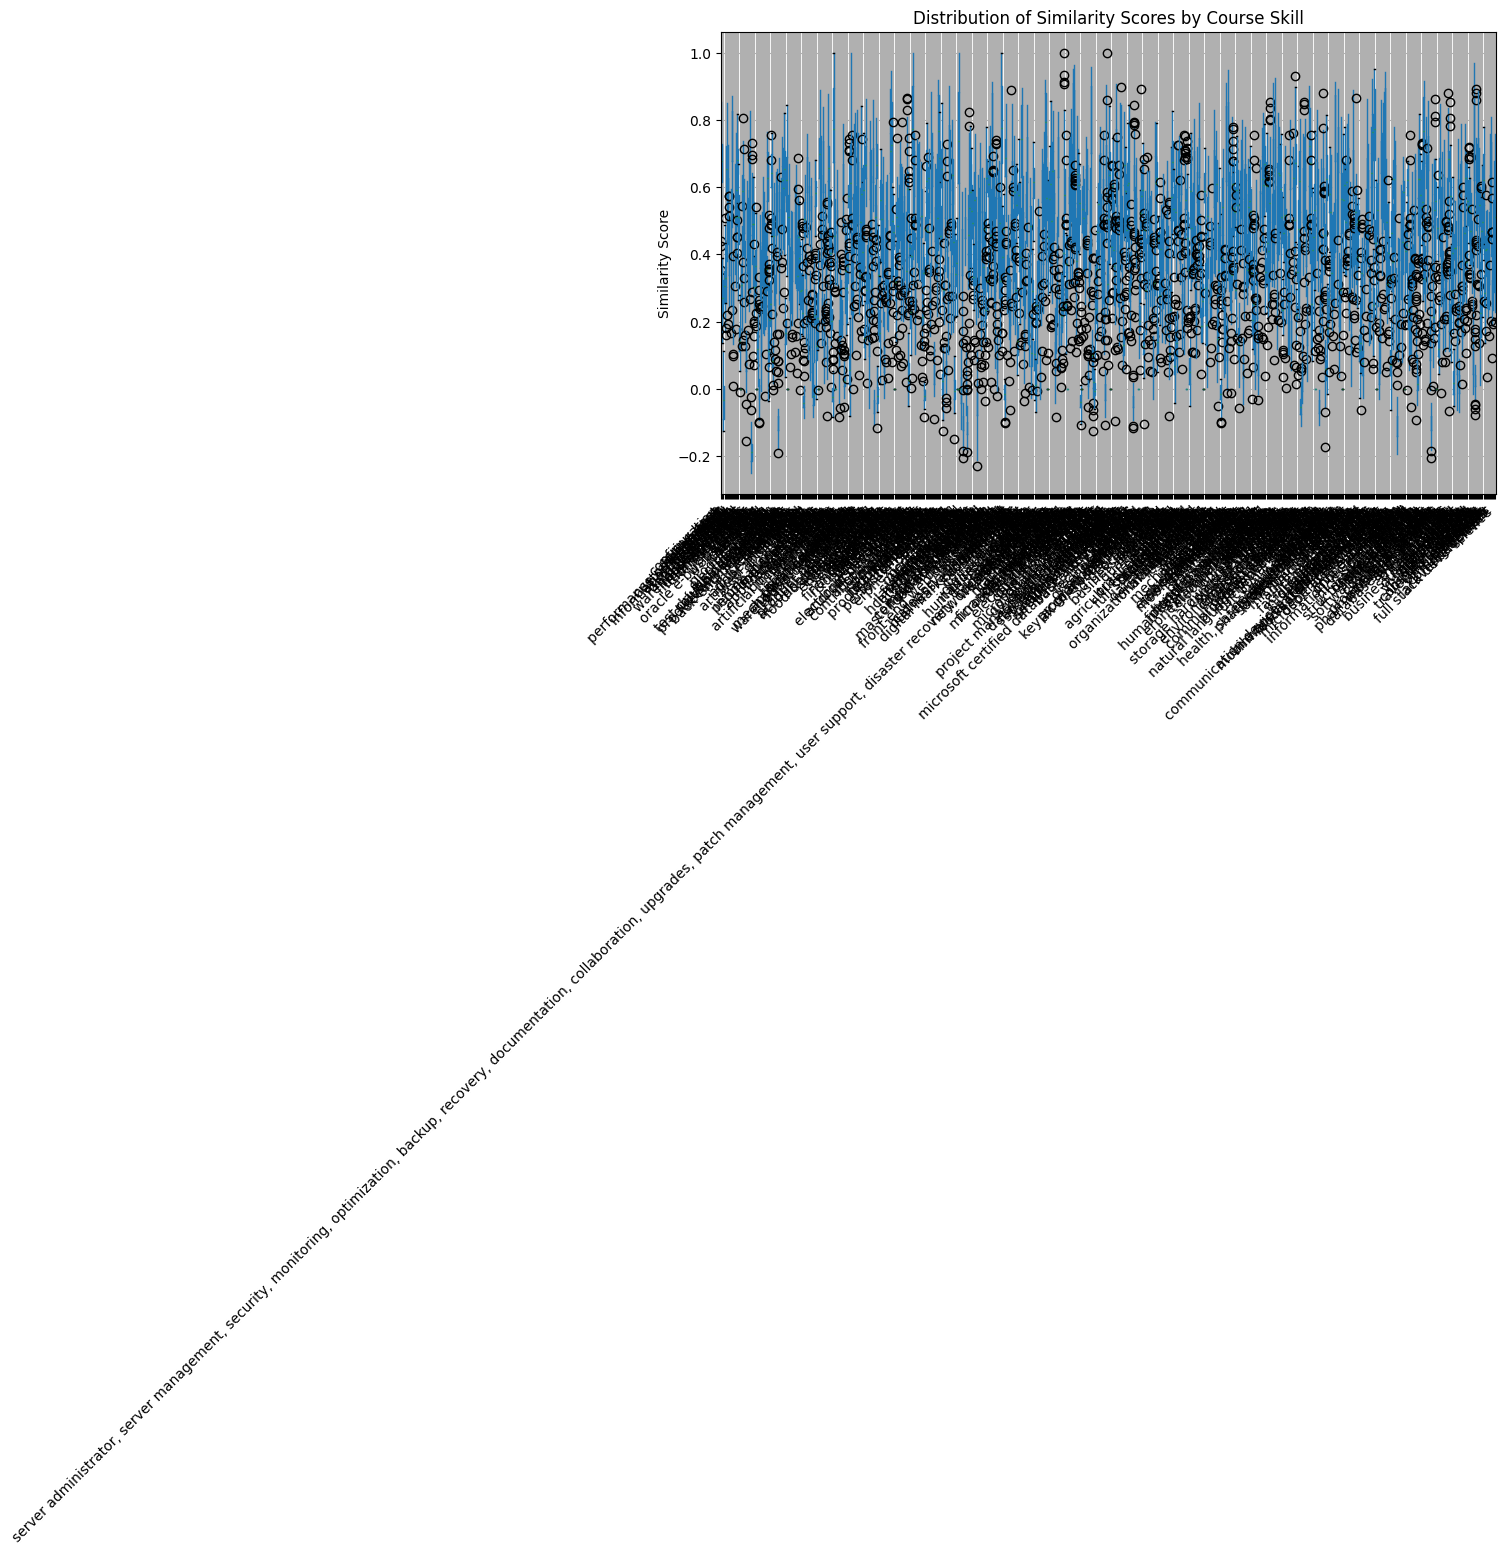

In [ ]:
plt.figure(figsize=(10, 6))
similarity_df.boxplot()
plt.title("Distribution of Similarity Scores by Course Skill")
plt.ylabel("Similarity Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(similarity_df, annot=True, cmap="YlOrRd", vmin=0, vmax=1)
plt.title("Similarity Between Course Skills and Job Skills")
plt.xlabel("Job Skills")
plt.ylabel("Course Skills")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("output/skill_heatmap.png")
plt.close()

# Bar Chart of Top Matches
top_matches = similarity_df.idxmax(axis=1)
top_scores = similarity_df.max(axis=1)
plt.figure(figsize=(10, 6))
top_scores.plot(kind='bar')
plt.title("Top Similarity Scores for Each Course Skill")
plt.xlabel("Course Skills")
plt.ylabel("Similarity Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("output/top_matches_bar.png")
plt.close()

print("Visualizations saved to output/ folder.")

<ipython-input-7-47b1b50bd988>:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Visualizations saved to output/ folder.


In [ ]:
# Summary statistics for each course skill
summary_stats = similarity_df.describe()
print("Summary Statistics of Similarity Scores:\n", summary_stats)

# Per course skill statistics
for course_skill in similarity_df.index:
    mean_score = similarity_df.loc[course_skill].mean()
    max_score = similarity_df.loc[course_skill].max()
    print(f"\n{course_skill}:")
    print(f"  Mean Similarity: {mean_score:.3f}")
    print(f"  Max Similarity: {max_score:.3f} (with {similarity_df.loc[course_skill].idxmax()})")

Summary Statistics of Similarity Scores:
        configuration  spring boot       acca  kubernetes  it manager  \
count      62.000000    62.000000  62.000000   62.000000   62.000000   
mean        0.666240     0.266918  -0.033530    0.308722    0.329832   
std         0.093870     0.063346   0.059702    0.075274    0.049579   
min         0.352278     0.137191  -0.126975    0.172382    0.160484   
25%         0.614373     0.211823  -0.088836    0.256085    0.303435   
50%         0.679019     0.269488  -0.032916    0.305211    0.328316   
75%         0.729448     0.322593   0.006698    0.349899    0.361337   
max         0.852447     0.389100   0.111262    0.509051    0.433152   

       performance management  customer support  erp admin  fastapi  \
count               62.000000         62.000000  62.000000     62.0   
mean                 0.640678          0.579266   0.380592      0.0   
std                  0.116746          0.086410   0.071962      0.0   
min                  0.21

In [ ]:
# Find top matches
top_matches = similarity_df.idxmax(axis=1)
top_scores = similarity_df.max(axis=1)

# Create a table
matches_table = pd.DataFrame({
    "Course Skill": top_matches.index,
    "Top Job Skill Match": top_matches.values,
    "Similarity Score": top_scores.values
})
print("\nTop Matches Table:\n", matches_table)


Top Matches Table:
                                    Course Skill  \
0                     efficient data processing   
1                               graph databases   
2            some key machine learning concepts   
3                    cs 673  scalable databases   
4   machine learning and data mining techniques   
..                                          ...   
57                          data privacy issues   
58                                 data mapping   
59                         database programming   
60              access, handle and process data   
61          prior python programming experience   

                                  Top Job Skill Match  Similarity Score  
0                                      data processor          0.940195  
1                                            graph ql          0.887855  
2                                    machine learning          0.809232  
3                                            adobe xd          0.68240

In [ ]:
threshold = 0.7
strong_matches = []
for course_skill in similarity_df.index:
    for job_skill in similarity_df.columns:
        if similarity_df.loc[course_skill, job_skill] >= threshold:
            strong_matches.append((course_skill, job_skill, similarity_df.loc[course_skill, job_skill]))

if strong_matches:
    print(f"\nStrong Matches (Similarity >= {threshold}):\n")
    for course, job, score in strong_matches:
        print(f"{course} -> {job}: {score:.3f}")
else:
    print(f"\nNo matches found above threshold {threshold}.")


Strong Matches (Similarity >= 0.7):

efficient data processing -> configuration: 0.733
efficient data processing -> information technology: 0.842
efficient data processing -> database design: 0.731
efficient data processing -> product testing: 0.749
efficient data processing -> information security: 0.763
efficient data processing -> implementation: 0.710
efficient data processing -> application security: 0.740
efficient data processing -> data science: 0.882
efficient data processing -> big data: 0.735
efficient data processing -> applications support: 0.730
efficient data processing -> automation: 0.767
efficient data processing -> product development: 0.706
efficient data processing -> account management: 0.712
efficient data processing -> document control: 0.729
efficient data processing -> system analysis: 0.783
efficient data processing -> data analyst: 0.851
efficient data processing -> data analysis: 0.911
efficient data processing -> master data: 0.879
efficient data processi

In [ ]:
# Step 5: Identify job skills not present in Pace courses
threshold_for_gap = 0.3  # If max similarity is below this, the job skill is considered missing
missing_skills = []
for job_skill in similarity_df.columns:
    max_similarity = similarity_df[job_skill].max()
    if max_similarity < threshold_for_gap:
        missing_skills.append((job_skill, max_similarity))

# Step 6: Report missing skills
if missing_skills:
    print("\nJob Market Skills Not Taught at Pace (Max Similarity < 0.3):\n")
    for job_skill, max_sim in missing_skills:
        print(f"{job_skill}: Max Similarity = {max_sim:.3f}")
else:
    print("\nAll job market skills have at least one match above the threshold.")

# Step 7: Append to the report
with open("output/skill_analysis_report.txt", "a") as f:
    f.write("\n\nJob Market Skills Not Taught at Pace (Max Similarity < 0.3):\n")
    if missing_skills:
        for job_skill, max_sim in missing_skills:
            f.write(f"{job_skill}: Max Similarity = {max_sim:.3f}\n")
    else:
        f.write("All job market skills have at least one match above the threshold.")
print("Missing skills analysis appended to output/skill_analysis_report.txt")


Job Market Skills Not Taught at Pace (Max Similarity < 0.3):

acca: Max Similarity = 0.111
fastapi: Max Similarity = 0.000
brm: Max Similarity = 0.000
six sigma: Max Similarity = 0.279
mvvn: Max Similarity = 0.000
laravel 5: Max Similarity = 0.173
ai: Max Similarity = -0.024
ehs: Max Similarity = 0.000
scrum: Max Similarity = 0.232
ml: Max Similarity = 0.146
lan: Max Similarity = 0.084
nosql: Max Similarity = 0.000
figma: Max Similarity = 0.270
erpnext: Max Similarity = 0.000
ocp: Max Similarity = 0.000
erdas: Max Similarity = 0.000
wan: Max Similarity = 0.195
react: Max Similarity = 0.263
restful: Max Similarity = 0.280
apis: Max Similarity = 0.077
fastlane: Max Similarity = 0.000
food & beverage: Max Similarity = 0.283
fmcg: Max Similarity = 0.108
webdynpro: Max Similarity = 0.000
mcitp: Max Similarity = 0.000
artificial intelligence (ai): Max Similarity = 0.205
ist: Max Similarity = 0.114
a+: Max Similarity = 0.211
iti: Max Similarity = 0.263
ax: Max Similarity = 0.111
abap/4: Max 

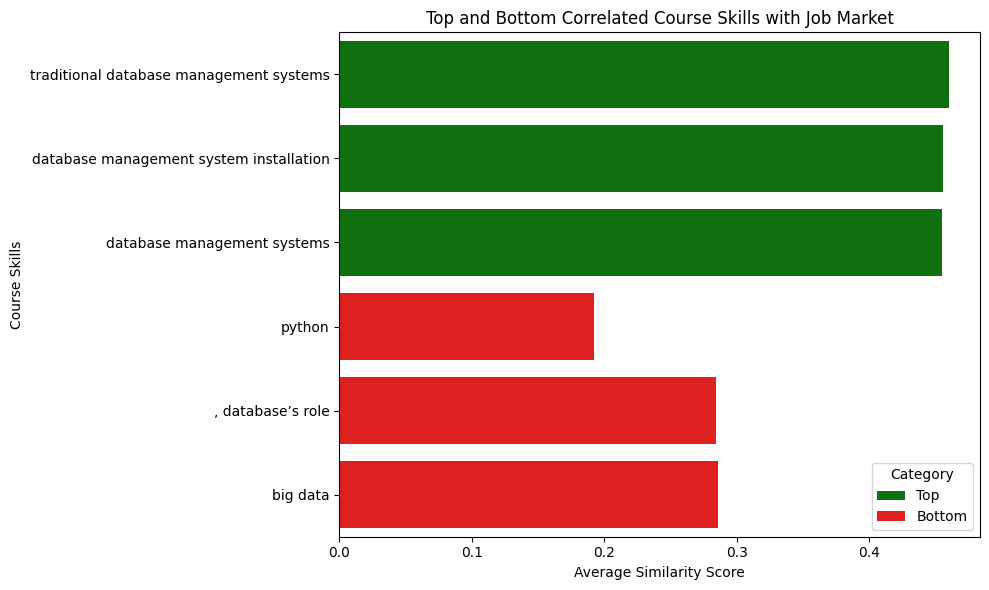

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 5: Calculate average similarity for each course skill (already done)
average_similarity = similarity_df.mean(axis=1)

# Step 6: Get top and bottom correlated skills
top_n = 3  # Number of top skills to display
bottom_n = 3  # Number of bottom skills to display

top_correlated = average_similarity.nlargest(top_n)
bottom_correlated = average_similarity.nsmallest(bottom_n)

# Step 7: Combine top and bottom for plotting
combined = pd.concat([top_correlated, bottom_correlated])
# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    "Course Skill": combined.index,
    "Average Similarity": combined.values,
    "Category": ["Top"] * top_n + ["Bottom"] * bottom_n
})

# Step 8: Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x="Average Similarity", y="Course Skill", hue="Category", data=plot_data, palette={"Top": "green", "Bottom": "red"})
plt.title("Top and Bottom Correlated Course Skills with Job Market")
plt.xlabel("Average Similarity Score")
plt.ylabel("Course Skills")
plt.tight_layout()

# Save the plot
#plt.savefig("output/top_bottom_correlated_skills.png")
#plt.close()
#print("Bar chart saved to output/top_bottom_correlated_skills.png")
plt.show()

<ipython-input-15-d98eca0ffee0>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


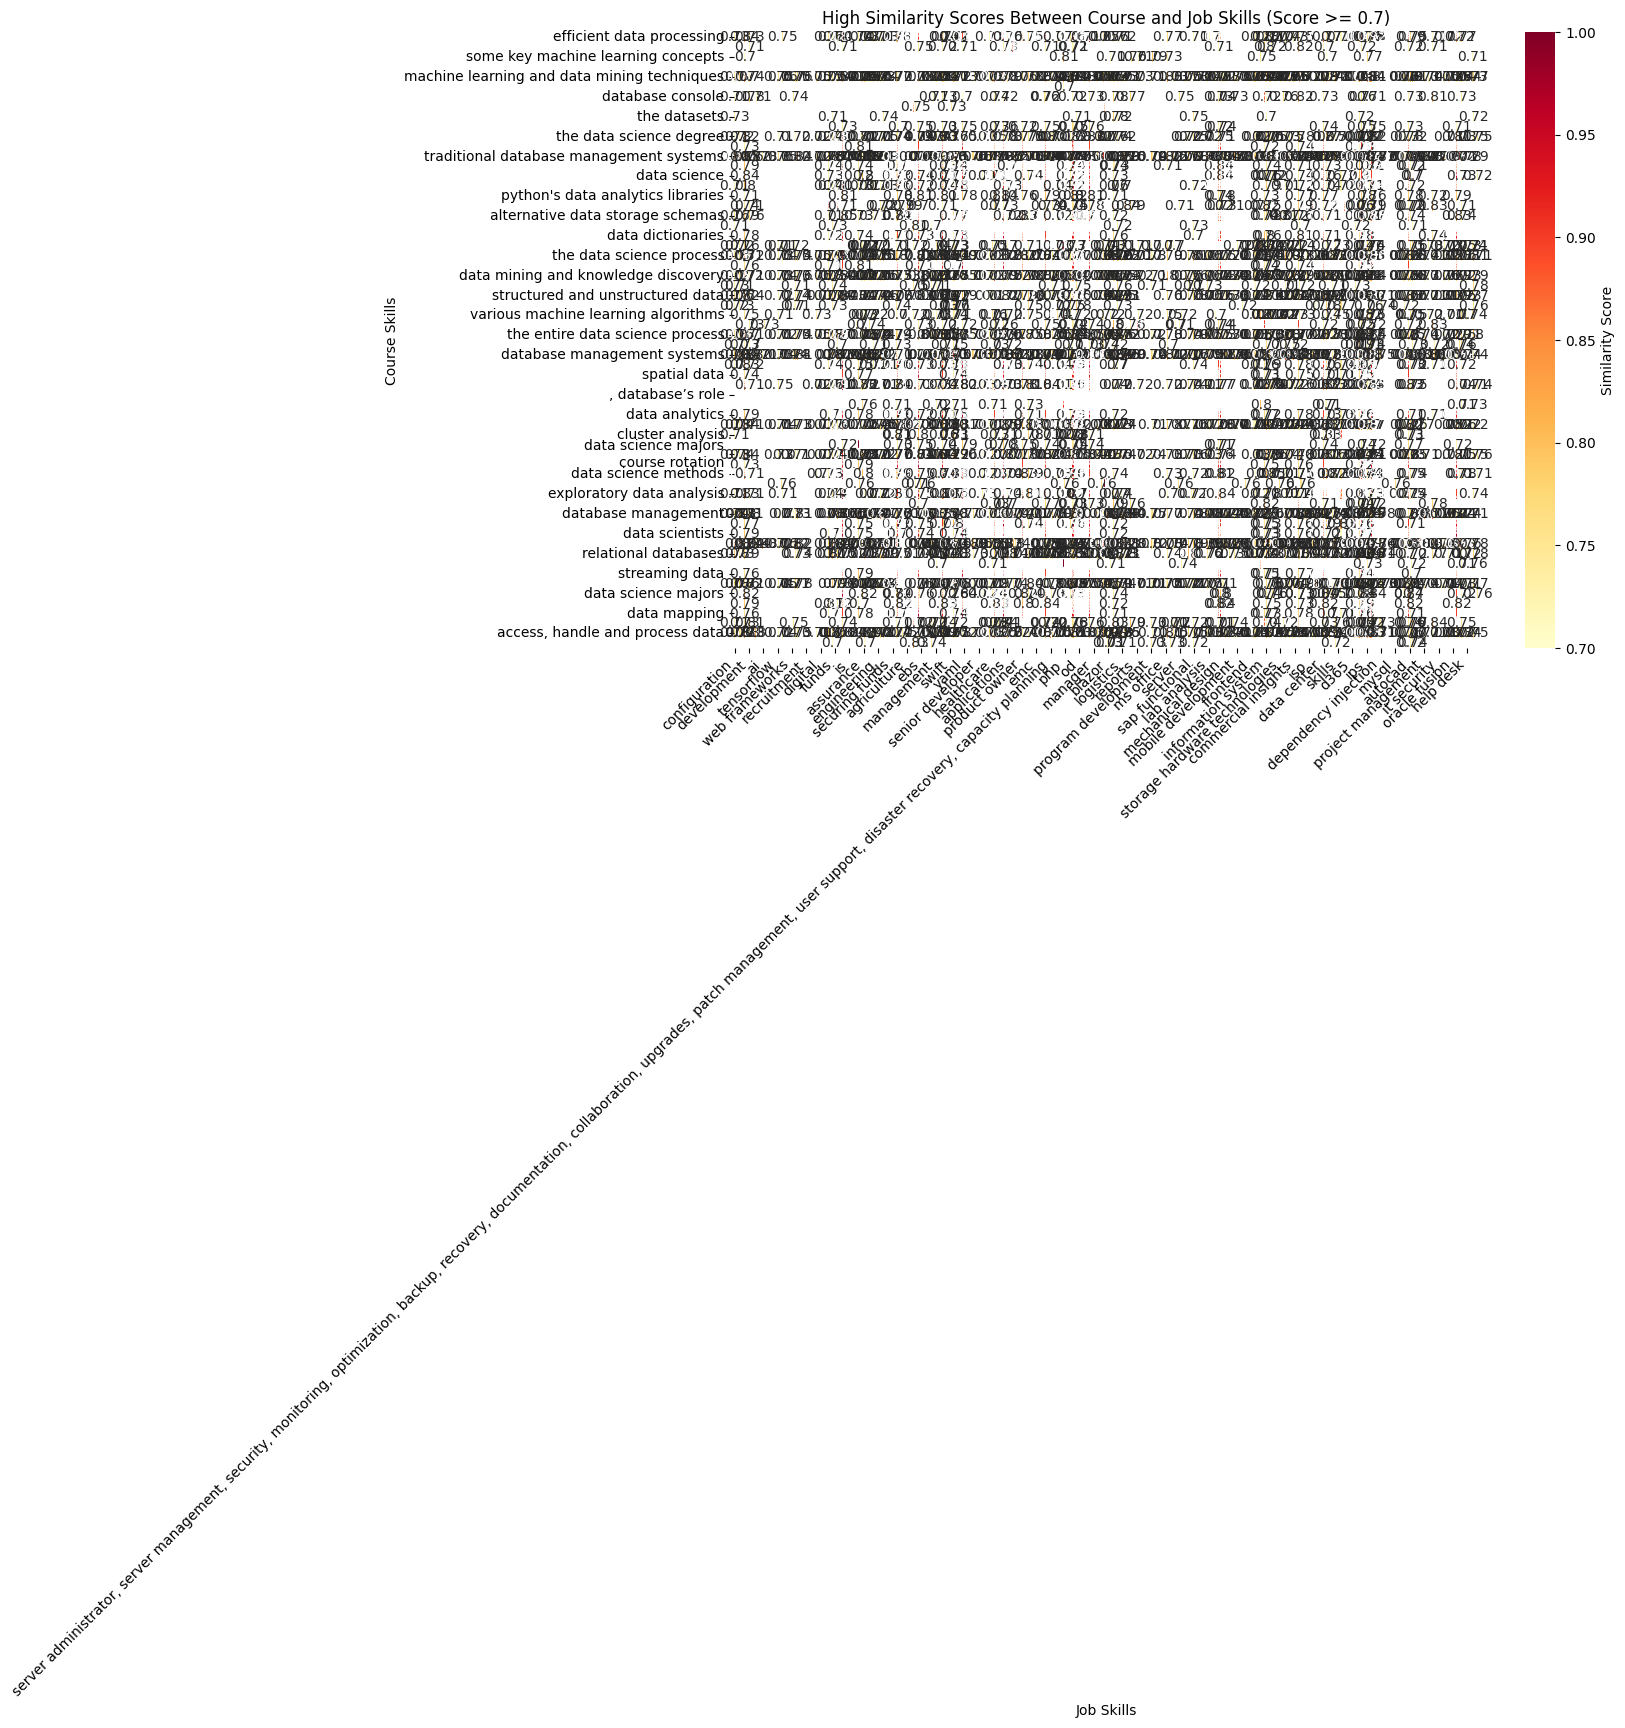

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for high similarity scores (e.g., >0.7)
threshold = 0.7
filtered_similarity_df = similarity_df.where(similarity_df >= threshold)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_similarity_df, annot=True, cmap="YlOrRd", vmin=threshold, vmax=1, cbar_kws={'label': 'Similarity Score'})
plt.title("High Similarity Scores Between Course and Job Skills (Score >= 0.7)")
plt.xlabel("Job Skills")
plt.ylabel("Course Skills")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot
#plt.savefig("output/high_similarity_heatmap.png")
#plt.close()
#print("Heatmap saved to output/high_similarity_heatmap.png")
plt.show()

<Figure size 1200x800 with 0 Axes>

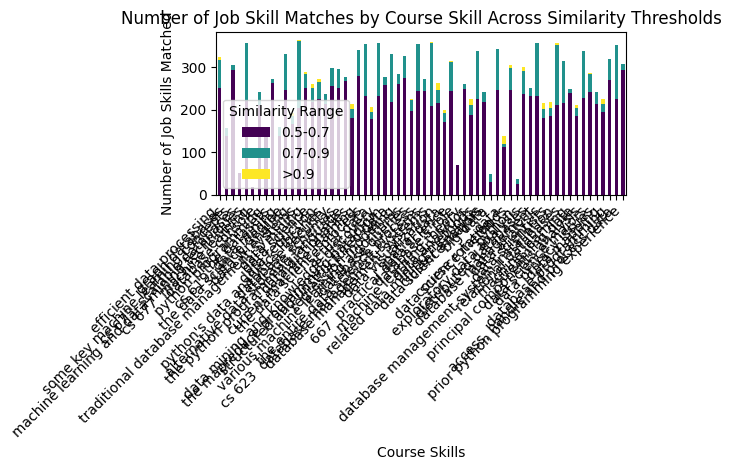

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define similarity thresholds
thresholds = [0.5, 0.7, 0.9]
labels = ['0.5-0.7', '0.7-0.9', '>0.9']

# Count matches in each range for each course skill
match_counts = pd.DataFrame(index=similarity_df.index, columns=labels)
for course_skill in similarity_df.index:
    scores = similarity_df.loc[course_skill]
    match_counts.loc[course_skill, '0.5-0.7'] = ((scores >= 0.5) & (scores < 0.7)).sum()
    match_counts.loc[course_skill, '0.7-0.9'] = ((scores >= 0.7) & (scores < 0.9)).sum()
    match_counts.loc[course_skill, '>0.9'] = (scores >= 0.9).sum()

# Plot stacked bar chart
plt.figure(figsize=(12, 8))
match_counts.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Number of Job Skill Matches by Course Skill Across Similarity Thresholds")
plt.xlabel("Course Skills")
plt.ylabel("Number of Job Skills Matched")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Similarity Range")
plt.tight_layout()

# Save the plot
#plt.savefig("output/match_counts_stacked_bar.png")
#plt.close()
#print("Stacked bar chart saved to output/match_counts_stacked_bar.png")
plt.show()

In [2]:
from sklearn.decomposition import NMF
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('/content/skill_comparison.csv')

# Save course names separately
course_names = df['Unnamed: 0']
X = df.drop(columns=['Unnamed: 0'])  # matrix of shape (courses x job skills)

# Ensure non-negative values for NMF by shifting the data
X = X.to_numpy()  # Convert to numpy array for easier manipulation
if X.min() < 0:
    X = X + abs(X.min())  # Shift all values to be non-negative
X = pd.DataFrame(X, columns=df.drop(columns=['Unnamed: 0']).columns)  # Convert back to DataFrame

# Apply NMF
nmf_model = NMF(n_components=10, init='random', random_state=42)
W = nmf_model.fit_transform(X)
H = nmf_model.components_

# Reconstruct the approximated matrix and add course names
X_approx = pd.DataFrame(W @ H, columns=X.columns)
X_approx['course'] = course_names

# Function to recommend skills
def recommend_skills(original, approx, course_index, top_n=5):
    original_row = original.iloc[course_index]
    approx_row = approx.iloc[course_index][original.columns]
    diff = approx_row - original_row
    recommended_skills = diff.sort_values(ascending=False).head(top_n)
    return recommended_skills

# Example: recommend for the first course
result = recommend_skills(X, X_approx, course_index=0, top_n=5)
print(result)

tableau             0.036792
3d geo-modelling    0.034528
deep learning       0.034312
spring boot         0.032673
geology             0.031571
Name: 0, dtype: object


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
